# Project 2: COVID19 Evolution

Jennifer Lin

jenniferyjlin@berkeley.edu

This document can also be viewed on this google colab link.

https://drive.google.com/file/d/1Xc0nmOdOj1-B7nvXc33qN89A_OMf4t3m/view?usp=sharing

I use google colab to do this final project. The following codes are required for installing the packages on google colab.


In [0]:
!pip install -q screed
!pip install -q biopython

# 0
Import packages


In [2]:
import screed # for reading in FASTA/FASTQ
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import statistics
from Bio.Phylo.TreeConstruction import _DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import Phylo

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1
Implement code in python or R to compare the Jaccard distance between k-mers of any length from these sequences. *feel free to use any existing fasta parsers

#### 1.1 Subfunction - `read_fasta`
This function reads the fasta file indicated by the `filename` and only retrieves the sequences part of the input file. The output `names_list` gives us a list of the names of the sequences and the `sequences_list` gives us a list of all the sequences in `filename`.

In [0]:
def read_fasta(filename):
    names_list = []
    sequences_list = []
    for record in screed.open(filename):
        names_list.append(record.name)
        sequences_list.append(record.sequence)
    print("Read in ", len(sequences_list)," sequences", sep="")
    return names_list, sequences_list

#### 1.2 Subfunction - `kmers`
This function takes in two arguments. Every element in `sequences_list` is a sequence. The `k` (k-mer) represents the length that we want to divide the sequence into. 
In the function, the `kmers_list` gives us a list of all possible k-mers in that `sequence`. The output `sequences_kmers_list` aggregates all the `kmers_list` for every sequences.

In [0]:
def kmers(sequences_list, k):
    sequences_kmers_list = []
    for sequence in sequences_list:
        kmers_list = []
        kmers_num = len(sequence) - k + 1
        for i in range(kmers_num):
            kmer_i = sequence[i:(i+k)]
            kmers_list.append(kmer_i)
        sequences_kmers_list.append(kmers_list)
    return sequences_kmers_list

#### 1.3 Subfunction - `jaccard_distance_2seq`
This function takes in kmers_list from two sequences respectively (i.e. `sequence_a_kmers_list` and `sequence_b_kmers_list`) and gives us the jaccard distance between these two sequences.

In [0]:
def jaccard_distance_2seq(sequence_a_kmers_list, sequence_b_kmers_list):
    sequence_a_kmers_set = set(sequence_a_kmers_list)
    sequence_b_kmers_set = set(sequence_b_kmers_list)
    intersection = len(sequence_a_kmers_set.intersection(sequence_b_kmers_set))
    union = len(sequence_a_kmers_set.union(sequence_b_kmers_set))
    return 1 - (intersection / union)

#### 1.4 Main function - `jaccard_distance_Nseq`
This function combines all subfunction 1.1, 1.2, and 1.3. Using this function, we can compare the Jaccard distance between k-mers of any length (`k`) from the sequences in `filename`. The output `jaccard_distance_list` returns a list of Jaccard distance for every unique pairs of sequences.

In [0]:
def jaccard_distance_Nseq(filename, k):
    names_list, sequences_list = read_fasta(filename)
    sequences_kmers_list = kmers(sequences_list, k)
    jaccard_distance_list = []
    for i in range(len(sequences_kmers_list)):
        sequence_a_kmers_set = set(sequences_kmers_list[i])
        for j in range(i+1,len(sequences_kmers_list)):
            sequence_b_kmers_set = set(sequences_kmers_list[j])
            jaccard_distance_i = jaccard_distance_2seq(sequence_a_kmers_set, sequence_b_kmers_set)
            jaccard_distance_list.append(jaccard_distance_i)
    return jaccard_distance_list

# 2 
Plot the distribution of inter-sequence Jaccard distances among all sequences for k=15, 30, 50, and 100. How do different k-mer lengths change the distribution of distances?

In [7]:
results = []
k_list = [15,30,50,100]
for k in k_list:
    result_i = jaccard_distance_Nseq("covid_sequences.fa",k)
    results.append(result_i)
# This takes around 5 minutes to run.

Read in 200 sequences
Read in 200 sequences
Read in 200 sequences
Read in 200 sequences


Text(0.5, 1.0, 'k=15')


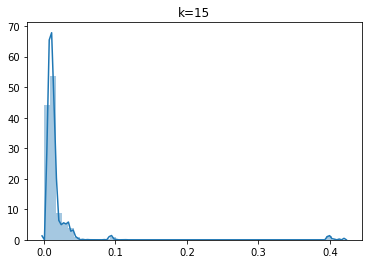

In [8]:
i = 0
print(sns.distplot(results[i]).set_title('k='+str(k_list[i])))

Text(0.5, 1.0, 'k=30')


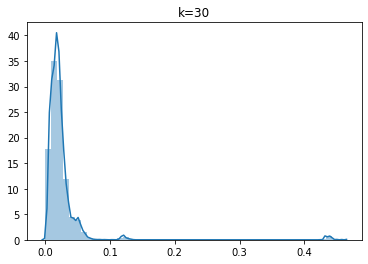

In [9]:
i = 1
print(sns.distplot(results[i]).set_title('k='+str(k_list[i])))

Text(0.5, 1.0, 'k=50')


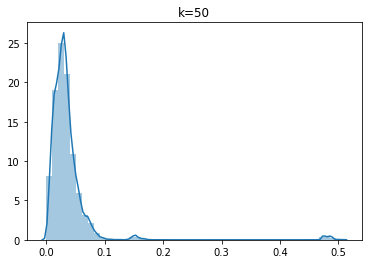

In [10]:
i = 2
print(sns.distplot(results[i]).set_title('k='+str(k_list[i])))

Text(0.5, 1.0, 'k=100')


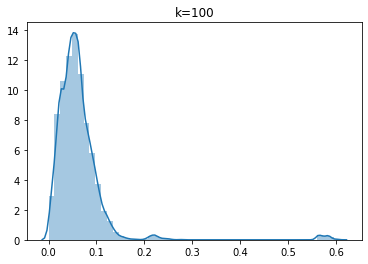

In [11]:
i = 3
print(sns.distplot(results[i]).set_title('k='+str(k_list[i])))

> When the k-mer length increases, the slices of the given sequences are longer. Hence, it is harder for us to find the exactly same slice in the k-mer sets between two sequences. As a result, when the k is higher, the distances would be higher. That's the reason why we can see the distribution of the distance shift to right when k increased.

# 3
Use the aligned sequences file to calculate the hamming distance between all pairs of
sequences. What happens when you ignore gaps (-) and N’s (N)?

#### `implement_func_on_pairs`
This function will help us implement the `FUNCTION` on all the unique pairs the input `filename` sequences. The `FUNCTION` will be built in 3.1 and 3.2.

In [0]:
def implement_func_on_pairs(filename, FUNCTION):
    names_list, sequences_list = read_fasta(filename)
    distance_matrix = []
    for i in range(len(sequences_list)):
        m_i = []
        for j in range(i+1):
            differences_ij = FUNCTION(sequences_list[i],sequences_list[j])
            m_i.append(differences_ij)
        distance_matrix.append(m_i)
    return names_list, distance_matrix

#### 3.1 Hamming distance including gaps(`-`) and Ns (`N`) - `hamming_distance_include_GN`
In this function, the gaps (`-`) and Ns (`N`) are considered as different characters from all other characters. As a result, we calculate the differences between thses 6 characters `A`, `C`, `G`, `T`, `-`, `N` in total. This function calculates and returns the `differences` between `sequence_a` and `sequence_b`. 

In [0]:
def hamming_distance_include_GN_2seq(sequence_a, sequence_b):
    differences = 0
    for nucleotide_a, nucleotide_b in zip(sequence_a, sequence_b):
        if nucleotide_a != nucleotide_b:
            differences += 1
    return differences

In [14]:
names_list_include_GN, distance_matrix_include_GN = implement_func_on_pairs("covid_aligned_sequences.aln", hamming_distance_include_GN_2seq)

Read in 200 sequences


In [15]:
print(distance_matrix_include_GN[:5])

[[0], [10148, 0], [10470, 1220, 0], [10710, 2044, 824, 0], [10941, 1869, 649, 733, 0]]


#### 3.2 Hamming distance ignoring gaps(`-`) and Ns (`N`) - `hamming_distance_ignore_GN`
In this function, the gaps (`-`) and Ns (`N`) are ignored. When there is at least a gap (`-`) or an N (`N`) in either of the current position of the two sequences, we do not consider the differences in this position anymore. As a result, we only calculate the differences between thses 4 characters `A`, `C`, `G`, `T`. This function calculates and returns the `differences` between `sequence_a` and `sequence_b`. 

In [0]:
def hamming_distance_ignore_GN_2seq(sequence_a, sequence_b):        
    differences = 0
    for nucleotide_a, nucleotide_b in zip(sequence_a, sequence_b):
        if nucleotide_a != nucleotide_b and nucleotide_a!="-" and nucleotide_a!="N" and nucleotide_b!="-" and nucleotide_b!="N": 
            differences += 1
    return differences

In [17]:
names_list_ignore_GN, distance_matrix_ignore_GN = implement_func_on_pairs("covid_aligned_sequences.aln", hamming_distance_ignore_GN_2seq)

Read in 200 sequences


In [18]:
print(distance_matrix_ignore_GN[:5])

[[0], [41, 0], [42, 1, 0], [41, 12, 11, 0], [43, 2, 1, 12, 0]]


#### 3.3 Compare the result of `hamming_distance_include_GN_2seq` and `hamming_distance_ignore_GN_2seq`

In [0]:
# include gaps and Ns
distances_include_GN = []
for distance_list in distance_matrix_include_GN:
    for distance in distance_list:
        distances_include_GN.append(distance)
# ignore gaps and Ns
distances_ignore_GN = []
for distance_list in distance_matrix_ignore_GN:
    for distance in distance_list:
        distances_ignore_GN.append(distance)

In [0]:
avg_include_GN = sum(distances_include_GN) / (len(distances_include_GN)-200) # The distance of the sequence and itself is 0. Hence, the 200 zeros would be excluded.
avg_ignore_GN = sum(distances_ignore_GN) / (len(distances_ignore_GN)-200) # The distance of the sequence and itself is 0. Hence, the 200 zeros would be excluded.
var_include_GN = statistics.variance(distances_include_GN)
var_ignore_GN = statistics.variance(distances_ignore_GN)

In [22]:
print("The average distance including gaps and Ns would be", round(avg_include_GN,2))
print("The average distance ignoring gaps and Ns would be", round(avg_ignore_GN,2))
print("The variance of the distances including gaps and Ns would be", round(var_include_GN,2))
print("The variance of the distances ignoring gaps and Ns would be", round(var_ignore_GN,2))

The average distance including gaps and Ns would be 217.7
The average distance ignoring gaps and Ns would be 9.5
The variance of the distances including gaps and Ns would be 1142372.62
The variance of the distances ignoring gaps and Ns would be 40.67


> Meanings of gaps and Ns
>> The gaps in one of the sequences mean that one or more nucleotide residues have been deleted from the sequence, or we could also say that there is an insertion in the another sequence. The Ns are undetermined nucleotides when sequencing these viral genome. Hence, Th Ns would possibly be `A`, `C`, `G`, or `T`.

> What happens when you ignore gaps (-) and N’s (N)?
>> When we ignore gaps and Ns, the average distance dropped from `217.7` to `9.5` nucleotides. The variance dropped from `1142372.62` to `40.67`. 
>>
>>This means that the differences caused by `A`, `C`, `G`, or `T` are only `9.5` nucleotides in average, whereas the differences caused by the gaps and Ns are far more than that (`217.7 - 9.5 = 208.2`). 
>>
>>This may because the viruses evolve/mutate very quickly. It would cause a lot of variations in the sequences. When doing the alignments, the program may need to generate a lot of the gaps to fill in these highly diverse regions.
>>
>> It would not make much sense if we use the unsure part of the sequences to determine the phylogeny of these sequences. As a result, in this case, it would be better if we use the distance matrix ignoring gaps and Ns for building the phylogenetic tree.


# 4
Build a tree using the UPGMA algorithm from hamming distances calculated excluding gapped sequence. Feel free to use existing R or python functions to perform UPGMA clustering, and plot the final tree.

#### 4.1
Before builing the tree, I decide to add the information of the country that the virus was discovered from in order to view their evolution more clearly. In order to do so, I read in the `covid_sequences.fa` again to get the country information from the `name_full_information`

In [21]:
name_full_information, sequences_not_used_here = read_fasta("covid_sequences.fa")
name_full_information[:5]

Read in 200 sequences


['LC528232 |Severe acute respiratory syndrome coronavirus 2 SARS-CoV-2/Hu/DP/Kng/19-020 RNA| complete genome||Severe acute respiratory syndrome-related coronavirus|',
 'LC528233 |Severe acute respiratory syndrome coronavirus 2 SARS-CoV-2/Hu/DP/Kng/19-027 RNA| complete genome||Severe acute respiratory syndrome-related coronavirus|',
 'LC529905 |Severe acute respiratory syndrome coronavirus 2 TKYE6182_2020 RNA| complete genome|Japan|Severe acute respiratory syndrome-related coronavirus|',
 'LC534418 |Severe acute respiratory syndrome coronavirus 2 SARS-CoV-2/Hu/DP/Kng/19-031 RNA| complete genome|Japan|Severe acute respiratory syndrome-related coronavirus|',
 'LC534419 |Severe acute respiratory syndrome coronavirus 2 SARS-CoV-2/Hu/Kng/19-437 RNA| complete genome|Japan|Severe acute respiratory syndrome-related coronavirus|']

I also build the `IDs` to `countries` dictionary (`IDs_countries_dict`) in order to add the country information them more easily.

In [25]:
# IDs
IDs = []
for n_i in name_full_information:
    n_i_split = n_i.split("|")
    id_i = n_i_split[0]
    IDs.append(id_i[:len(id_i)-1]) # remove version .X
print("IDS:", IDs[:5])
# countries
countries = []
for n_i in name_full_information:
    n_i_split = n_i.split("|")
    country = n_i_split[len(n_i_split)-3]
    if country == "":
        country = "N/A"
    countries.append(country)
print("countries:", countries[:5]) # The first two entries do not have country information
# IDs to countries dictionary
IDs_countries_dict = {}
for i in range(len(countries)):
    IDs_countries_dict[IDs[i]] = countries[i]
print("IDs_countries_dict:", IDs_countries_dict)

IDS: ['LC528232', 'LC528233', 'LC529905', 'LC534418', 'LC534419']
countries: ['N/A', 'N/A', 'Japan', 'Japan', 'Japan']
IDs_countries_dict: {'LC528232': 'N/A', 'LC528233': 'N/A', 'LC529905': 'Japan', 'LC534418': 'Japan', 'LC534419': 'Japan', 'LC542809': 'Japan', 'LC542976': 'Japan', 'LR757995': 'China', 'LR757996': 'China', 'LR757997': 'China', 'LR757998': 'China', 'MN908947': 'China', 'MN938384': 'China', 'MN975262': 'China', 'MN985325': 'USA', 'MN988668': 'China', 'MN988669': 'China', 'MN988713': 'USA', 'MN994467': 'USA', 'MN994468': 'USA', 'MN996527': 'China', 'MN996528': 'China', 'MN996529': 'China', 'MN996530': 'China', 'MN996531': 'China', 'MN997409': 'USA', 'MT007544': 'Australia', 'MT012098': 'India', 'MT019529': 'China', 'MT019530': 'China', 'MT019531': 'China', 'MT019532': 'China', 'MT019533': 'China', 'MT020781': 'Finland', 'MT020880': 'USA', 'MT020881': 'USA', 'MT027062': 'USA', 'MT027063': 'USA', 'MT027064': 'USA', 'MT039873': 'China', 'MT039874': 'China', 'MT039887': 'USA'

Convert the `names` in `names_list_ignore_GN` (from 3.2) to `names_IDs_countries`.

In [24]:
names = names_list_ignore_GN # from 3.2
names_IDs_countries = []
for n_i in names:
    n_i_split = n_i.split("|")
    id_i = n_i_split[1]
    ID = id_i[:len(id_i)-2] # remove version .X
    country = IDs_countries_dict[ID]
    names_IDs_countries.append(ID + "_" +country)
print("original names:", names[:5])
print("new names:",names_IDs_countries[:5])

original names: ['emb|LR757997.1', 'gb|MT198651.1', 'gb|MT233520.1', 'gb|MT246465.1', 'gb|MT233521.1']
new names: ['LR757997_China', 'MT198651_Spain', 'MT233520_Spain', 'MT246465_USA', 'MT233521_Spain']


#### 4.1 Create the `dm` which belongs to the `_DistanceMatrix` class

In [0]:
names = names_IDs_countries # from 3.2
matrix = distance_matrix_ignore_GN # from 3.2
dm = _DistanceMatrix(names, matrix)

In [27]:
dm

DistanceMatrix(names=['LR757997_China', 'MT198651_Spain', 'MT233520_Spain', 'MT246465_USA', 'MT233521_Spain', 'MT198653_Spain', 'MT246483_USA', 'MT252692_USA', 'MT246463_USA', 'MT246458_USA', 'MT233522_Spain', 'MT246456_USA', 'MT163721_USA', 'MT252693_USA', 'MT246485_USA', 'MT226610_China', 'MT246468_USA', 'MT246473_USA', 'MT251973_USA', 'MT039890_South Korea', 'MN988713_USA', 'MT184911_USA', 'MT093571_Sweden', 'MT123291_China', 'MT123293_China', 'MT184910_USA', 'MT019530_China', 'MT240479_Pakistan', 'MT184908_USA', 'MT184913_USA', 'MT246454_USA', 'MT163716_USA', 'MT039888_USA', 'MT012098_India', 'MT159712_USA', 'MT186683_Hong Kong', 'MT027063_USA', 'MT027062_USA', 'LC542809_Japan', 'MT114415_Hong Kong', 'MT114414_Hong Kong', 'MT007544_Australia', 'MT019529_China', 'LC529905_Japan', 'MT159722_USA', 'MT159705_USA', 'MT126808_Brazil', 'MT066156_Italy', 'MT123290_China', 'LC528233_N/A', 'MN996531_China', 'MN996529_China', 'MT066176_Taiwan', 'MN994468_USA', 'MT159717_USA', 'MT159718_USA', 

*The following table would exceed the page size limit. Please see `4.1_dm.txt` in the porvided files in `FinalProject2_JenniferLin` folder.*

In [0]:
print(dm)

#### 4.2 Construct the `tree` using UPGMA

In [0]:
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

#### 4.3 Visualize the `tree`

*The following plot would exceed the page size limit. Please see `4.3_phylogenetic_tree_UPGMA.png` in the porvided files in `FinalProject2_JenniferLin` folder or the last part `8 figures` of this document.*

In [0]:
matplotlib.rc('font', size=6)
fig = plt.figure(figsize=(15, 40), dpi=300)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)
plt.savefig("4.3_phylogenetic_tree_UPGMA.png", dpi=300)

# 5
Write up a few sentences about what you infer from this tree and the evolution of the
virus across the world.

> China origins
>> In the deepest root (`inner 199`), it divides all the data to `LR757997_China` and other cases. In the second deepest root (`inner 198`), it divides all the data to `MT226610_China` and other cases. Consequently, these two strains may be the very first origins of all the COVID-19 strains in the world.

> USA early branch
>> In the third deepest root (`inner 197`), `MT246487_USA` was evolved. This means this strain in USA may be the most close relative to th China original strains, Nevertheless, this strin did not evolve to other strains in our dataset, which may be due to the reason that we did not get the enough sample from them. 

> USA cluster (`inner192`)
>> The viruses from the first big cluster (`inner192`) were all discovered from USA. This tells us the sequences of these virus are all similar to each other and thus they may come from the same origin.

> USA + Other countries clusters (`inner 195`)
>> In the second big cluster (`inner 195`), we can see a lot of countries mixed together. Because a lot of the samples come from USA, we can see some of the cases in USA are very close to cases in South Korea (`inner 194`) or Spain (`inner 84`) etc.

> Asian clusters
>> As for other countries, we can see most of the Asian countries are cluster together (e.g., Japan, Hong Kong, Taiwan, China, Vietnam, Nepal, and Australia). This means the strains in these countries are close relatives. It may be due to the fact that these countries are geographically close to each other and hence it is easy for the virus to spread in these countries. 
>>
>> Some of the cases in USA or Europe (e.g., Italy, Finland, Sweden) are clustered in the Asian clusters as well. This shows that these cases may have interacted with the Asian cases and thus got infected.
>>
>> In the last clusterm, cases from India and Pakistan seem to cluster together although we actually may not have enough cases to validate this.

> Spain cluster
>> Althogh we do not have a lot of cases from Europe in this dataset, we can still see most of the cases in the last small cluster are from Spain, which indicated the close relationship of these strains in Spain.





# 6 Bonus
How is the data presented on https://nextstrain.org an improvement on the results generated here?

> I think the data presented on Nextstrain website is better because it provides not only the global analysis but also the analyses for local regions separately. It provides the analysis for North America, Europe, Asia, Oceania, Africa, and South America. Sometimes conducting analyses on separeted regions would help us understand more about the evolution of the viruses.

> In addition, it provides the information for different kinds of pathogens and the communities that these pathogens form.

> Lastly, it provides a lot of interactive figures for the users to play with. For example, in phylogenetic plots, we can choose to highlight the countries that we are interested in. It also offers the global map of the transmission of the viruses. These interesting figures definitely help us a lot for understanding the phylogeny of these viruses.

# 7 Others

I also tried to use other popular phylogenetic programs to build the phylotgenetic trees. The results of the following two trees show similar topologies as the tree built by UPGMA alogorithm in Python.

7.1 RAxML (using maximum likelihood algorithm)

*The following plot would exceed the page size limit. Please see `7.1_phylogenetic_tree_RaxML.png` in the porvided files in `FinalProject2_JenniferLin` folder or the last part `8 figures` of this document.*

In [0]:
tree_RAxML = Phylo.read('covid_RAxML.nwk', 'newick')
matplotlib.rc('font', size=6)
fig = plt.figure(figsize=(15, 40), dpi=300)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)
plt.savefig("7.1_phylogenetic_tree_RaxML.png", dpi=300)

7.2 MrBayes (using Bayesian inference algorithm)

*The following plot would exceed the page size limit. Please see `7.2_phylogenetic_tree_MrBayes.png` in the porvided files in `FinalProject2_JenniferLin` folder or the last part `8 figures` of this document.*

In [0]:
tree_MrBayes = Phylo.read('covid_MrBayes.nwk', 'newick')
matplotlib.rc('font', size=6)
fig = plt.figure(figsize=(15, 40), dpi=300)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)
plt.savefig("7.2_phylogenetic_tree_MrBayes.png", dpi=300)

# 8 Figures

(see next three pages)